In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dpt1-dataset/DPT1.xlsx
/kaggle/input/lpt-datasett/LPT.xlsx
/kaggle/input/lct-dataset/LCT.xlsx
/kaggle/input/lpt-1-dataset/LPT 1.xlsx
/kaggle/input/lb-dataset/LB.xlsx
/kaggle/input/lpt-2-dataset/LPT 2.xlsx


In [2]:
!pip install mpl-chord-diagram
!pip install eli5

  Preparing metadata (setup.py) ... done
  Created wheel for mpl-chord-diagram: filename=mpl_chord_diagram-0.4.1-py2.py3-none-any.whl size=16686 sha256=b20bf8e5d82747b00ae013090d4a78967d73a69ffa5f4836dbfdf2dcc8aae1e7
  Stored in directory: /root/.cache/pip/wheels/e3/63/c5/7c88ede73f3c7d4921eeb8f1d620a7c7311992c4a452442334
Successfully built mpl-chord-diagram


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
import eli5
from mpl_chord_diagram import chord_diagram
import re

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-04-01 14:53:27.714738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 14:53:27.714832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 14:53:27.879882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.random.seed(45)

In [5]:
df = pd.read_excel("/kaggle/input/lb-dataset/LB.xlsx")

In [6]:
df.head()

,PATIENT,DOSE,AGE,WEIGHT,HEIGHT,CR,PSA,ALP,WBC,RBC,HB,HCT,BU,P,CA,GS,NofPreT
0,PT8.nii,1.618629,79,80.0,175.0,0.8,14.36,101.0,5.84,4.18,12.6,38.4,47.0,4.85,9.7,7.0,2.0
1,PT8.nii,1.630956,79,80.0,175.0,0.8,14.36,101.0,5.84,4.18,12.6,38.4,47.0,4.85,9.7,7.0,2.0
2,PT8.nii,1.208252,79,80.0,175.0,0.8,14.36,101.0,5.84,4.18,12.6,38.4,47.0,4.85,9.7,7.0,2.0
3,PT10.nii,5.183656,64,85.0,176.0,NaN,17.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0
4,PT10.nii,5.150140,64,85.0,176.0,NaN,17.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0


In [7]:
df.shape

(130, 17)

In [8]:
df.dtypes

PATIENT     object
DOSE       float64
AGE          int64
WEIGHT     float64
HEIGHT     float64
CR         float64
PSA        float64
ALP        float64
WBC        float64
RBC        float64
HB         float64
HCT        float64
BU         float64
P          float64
CA         float64
GS         float64
NofPreT    float64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PATIENT  130 non-null    object 
 1   DOSE     130 non-null    float64
 2   AGE      130 non-null    int64  
 3   WEIGHT   130 non-null    float64
 4   HEIGHT   114 non-null    float64
 5   CR       115 non-null    float64
 6   PSA      130 non-null    float64
 7   ALP      93 non-null     float64
 8   WBC      115 non-null    float64
 9   RBC      104 non-null    float64
 10  HB       115 non-null    float64
 11  HCT      74 non-null     float64
 12  BU       67 non-null     float64
 13  P        76 non-null     float64
 14  CA       76 non-null     float64
 15  GS       63 non-null     float64
 16  NofPreT  96 non-null     float64
dtypes: float64(15), int64(1), object(1)
memory usage: 17.4+ KB


In [10]:
df.drop("PATIENT", axis = 1, inplace=True)

In [11]:
df.isna().sum()

DOSE        0
AGE         0
WEIGHT      0
HEIGHT     16
CR         15
PSA         0
ALP        37
WBC        15
RBC        26
HB         15
HCT        56
BU         63
P          54
CA         54
GS         67
NofPreT    34
dtype: int64

In [12]:
df.columns[df.isna().any()]

Index(['HEIGHT', 'CR', 'ALP', 'WBC', 'RBC', 'HB', 'HCT', 'BU', 'P', 'CA', 'GS',
       'NofPreT'],
      dtype='object')

In [13]:
df = df.fillna(df.median())

In [14]:
df.isna().sum()

DOSE       0
AGE        0
WEIGHT     0
HEIGHT     0
CR         0
PSA        0
ALP        0
WBC        0
RBC        0
HB         0
HCT        0
BU         0
P          0
CA         0
GS         0
NofPreT    0
dtype: int64

In [15]:
df.columns

Index(['DOSE', 'AGE', 'WEIGHT', 'HEIGHT', 'CR', 'PSA', 'ALP', 'WBC', 'RBC',
       'HB', 'HCT', 'BU', 'P', 'CA', 'GS', 'NofPreT'],
      dtype='object')

<Axes: >

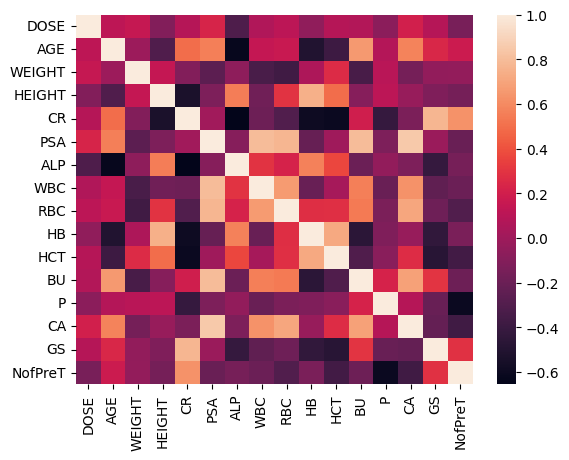

In [16]:
sns.heatmap(df.corr())

In [17]:
def calculate_scores(y, y_pred):
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    return r2, mae, mse

In [18]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [19]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [20]:
# This function evaluates the performance of a model over multiple iterations
# using bootstrapping and KFold cross-validation with 5 splits.

def evaluate_model(X, y, model, n_iterations=500, sample_size=0.6, print_results=True):
    r2_train_scores = []
    mae_train_scores = []
    mse_train_scores = []
    rmse_train_scores = []

    r2_test_scores = []
    mae_test_scores = []
    mse_test_scores = []
    rmse_test_scores = []
    
    # K-fold cross-validation with k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for i in range(n_iterations):
        
        # Bootstrap resampling of the data
        X_boot, y_boot = resample(X, y, replace=True, n_samples=int(sample_size * len(X)), random_state=32)
        
        r2_train_fold_scores = []
        mae_train_fold_scores = []
        mse_train_fold_scores = []
        
        r2_test_fold_scores = []
        mae_test_fold_scores = []
        mse_test_fold_scores = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(X_boot), 1):
            X_train, X_test = X_boot[train_index], X_boot[test_index]
            y_train, y_test = y_boot.iloc[train_index], y_boot.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calculate metrics
            r2_train, mae_train, mse_train = calculate_scores(y_train, y_train_pred)
            
            r2_test, mae_test, mse_test = calculate_scores(y_test, y_test_pred)
            
            # Append scores for this fold
            r2_train_fold_scores.append(r2_train)
            mae_train_fold_scores.append(mae_train)
            mse_train_fold_scores.append(mse_train)
            
            r2_test_fold_scores.append(r2_test)
            mae_test_fold_scores.append(mae_test)
            mse_test_fold_scores.append(mse_test)
            

        # Append mean scores for this iteration
        r2_train_scores.append(np.mean(r2_train_fold_scores))
        mae_train_scores.append(np.mean(mae_train_fold_scores))
        mse_train_scores.append(np.mean(mse_train_fold_scores))
        rmse_train_scores.append(np.sqrt(np.mean(mse_train_fold_scores)))
        
        r2_test_scores.append(np.mean(r2_test_fold_scores))
        mae_test_scores.append(np.mean(mae_test_fold_scores))
        mse_test_scores.append(np.mean(mse_test_fold_scores))
        rmse_test_scores.append(np.sqrt(np.mean(mse_test_fold_scores)))

    if (print_results):
        # Train scores
        print_scores('Train', r2_train_scores, mae_train_scores, mse_train_scores, rmse_train_scores)
        
        # Test scores
        print_scores('Test', r2_test_scores, mae_test_scores, mse_test_scores, rmse_test_scores)
    
    return np.mean(r2_test_scores), np.mean(mse_test_scores)

In [21]:
# This function evaluates the performance of a GradientBoostingRegressor model based on the number of selected features.
# It iterates over different numbers of selected features, starting from 8 down to 1.

def evaluate_based_on_feature_number(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:

def evaluate_based_on_feature_number2(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Plot R^2 Score
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Mean Squared Error (MSE)
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
# For simpler visualization
def get_simple_feature_name(feature_names):
    simple_names = []
    for feature_name in feature_names:
        simple_name=feature_name
        pattern = r'\((.*)'
        match = re.search(pattern, feature_name)
        if match:
            simple_name = match.group(1)
            if simple_name in simple_names:
                last_underscore_index = feature_name.rfind('_')
                simple_name = feature_name[last_underscore_index:] if last_underscore_index != -1 else feature_name
        simple_names.append(simple_name)
    return simple_names

In [24]:
def hist_plot(df):
    df_renamed = df.copy()
    df_renamed.columns = get_simple_feature_name(df.columns)
    df_renamed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [25]:
def pair_plot(X, y):
    X_renamed = X.copy()
    X_renamed.columns = get_simple_feature_name(X.columns)
    y_df = y.to_frame().rename(columns={0: 'Dose'})
    df = pd.concat([X_renamed, y_df], axis=1)
    for i in range(0, len(df.columns), 5):
        sns.pairplot(data=df,
                     x_vars=df.columns[i:i+5],
                     y_vars=['DOSE'])

In [26]:
def plot_chord_diagram(X):
    fig, ax = plt.subplots(figsize=(12, 12))
    chord_diagram(X.corr(), names=get_simple_feature_name(X.columns), ax=ax, rotation=0, fontsize=8)
    plt.show()

In [27]:
y=df['DOSE']
X=df.drop('DOSE', axis=1)

In [28]:
X_scaled = StandardScaler().fit_transform(X)

Section 1: Three-Step Feature Selection using Lasso Regression, Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [29]:
# Step 1: Initial feature selection using Lasso regression
# Eliminating features with lasso coef of 0
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature AGE (-0.019130)
2. Feature WEIGHT (0.928648)
3. Feature HEIGHT (0.315684)
4. Feature CR (2.417820)
5. Feature PSA (0.940297)
6. Feature ALP (-3.632769)
7. Feature WBC (5.470801)
8. Feature RBC (-1.739363)
9. Feature HB (5.058063)
10. Feature HCT (0.042060)
11. Feature BU (0.374430)
12. Feature P (1.810638)
13. Feature CA (-3.060089)
14. Feature NofPreT (0.000000)


In [30]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

Weight?,Feature
+5.471,WBC
+5.058,HB
+2.418,CR
+2.106,<BIAS>
+1.811,P
+0.940,PSA
+0.929,WEIGHT
+0.374,BU
+0.316,HEIGHT
+0.042,HCT


In [31]:
X_selected = X[selected_features]

In [32]:
X_selected.columns

Index(['AGE', 'WEIGHT', 'HEIGHT', 'CR', 'PSA', 'ALP', 'WBC', 'RBC', 'HB',
       'HCT', 'BU', 'P', 'CA', 'NofPreT'],
      dtype='object')

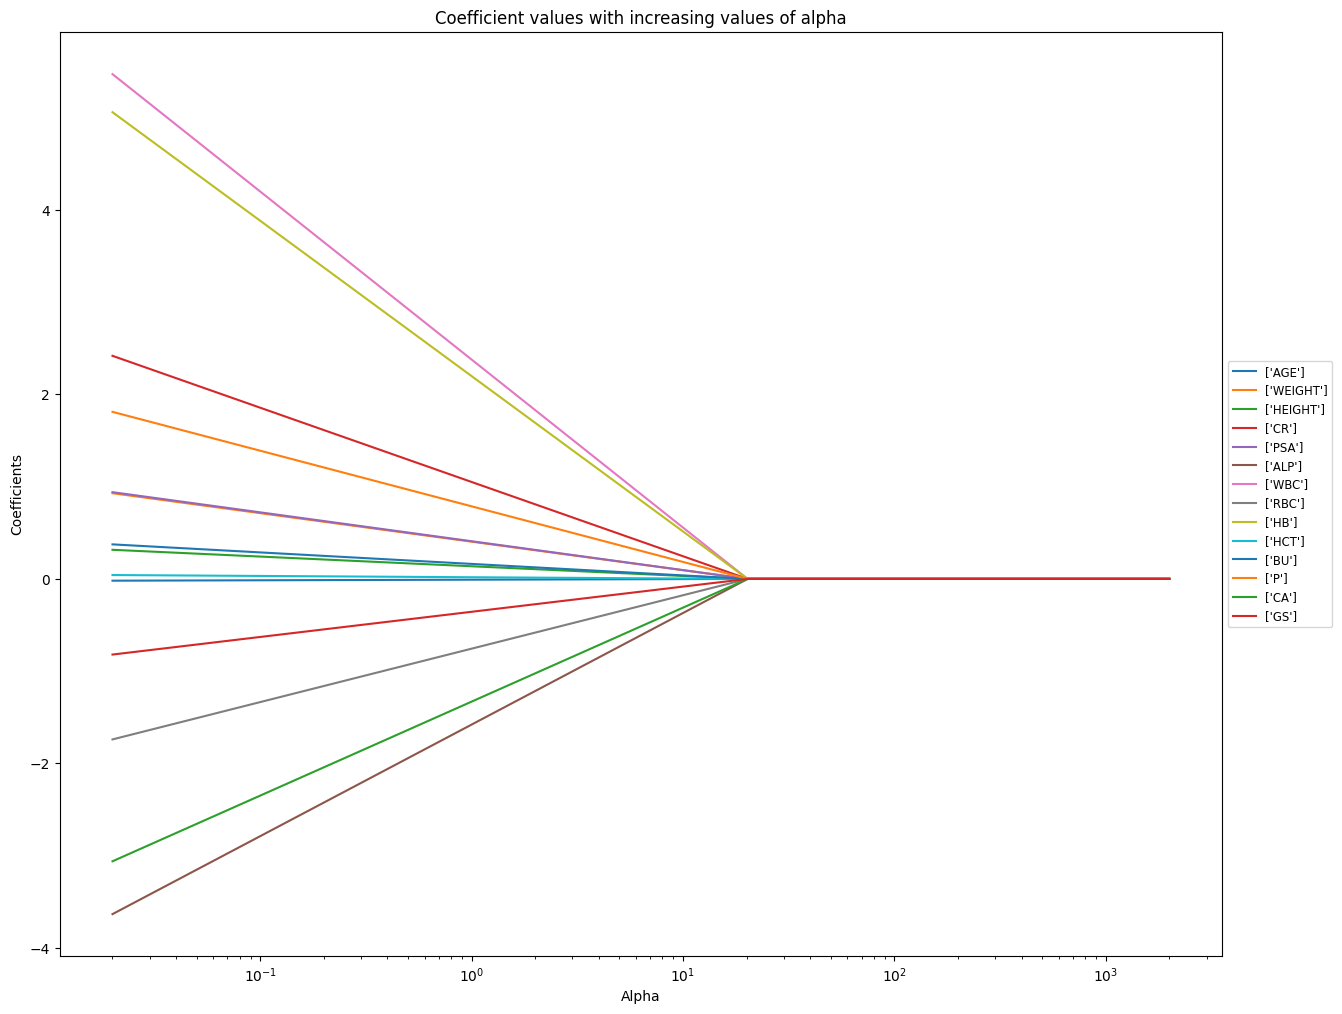

In [33]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

# Plot each feature's coefficient against alpha
ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()



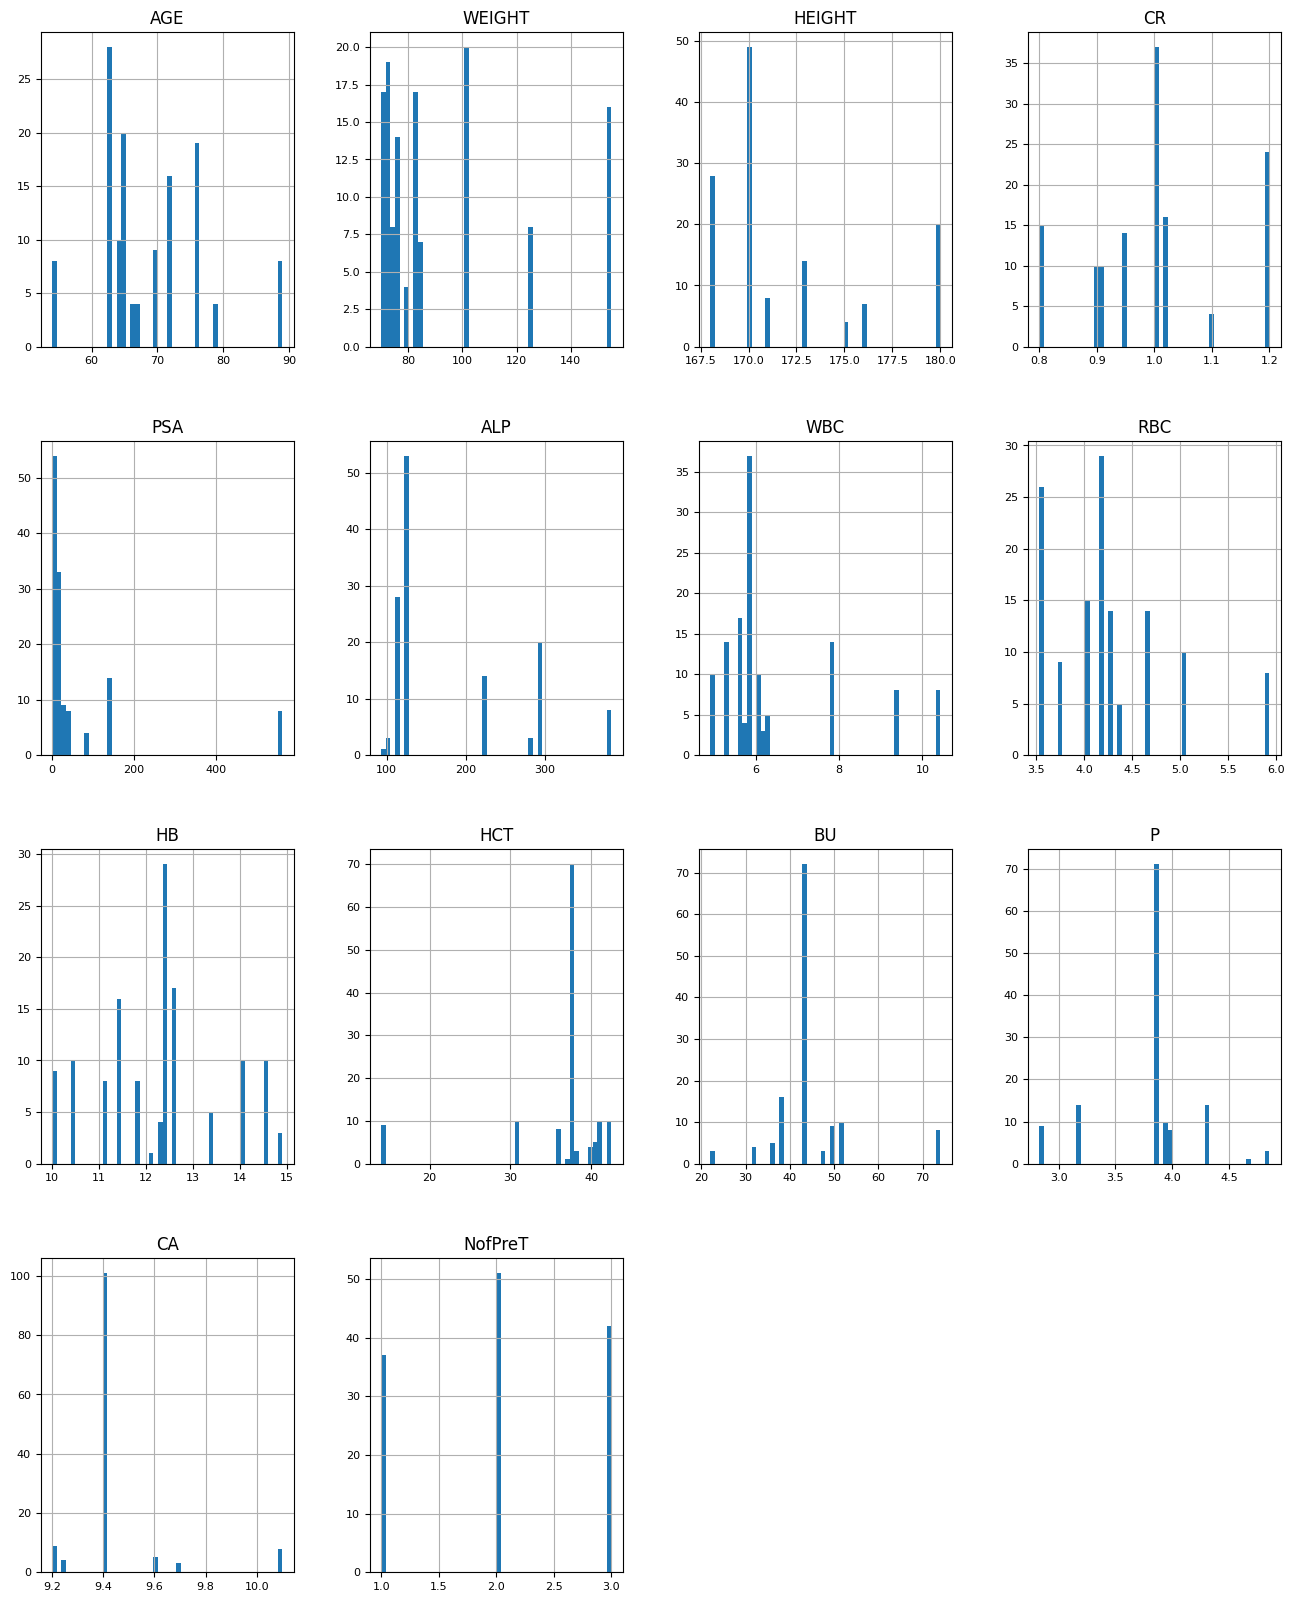

In [34]:
hist_plot(X_selected)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


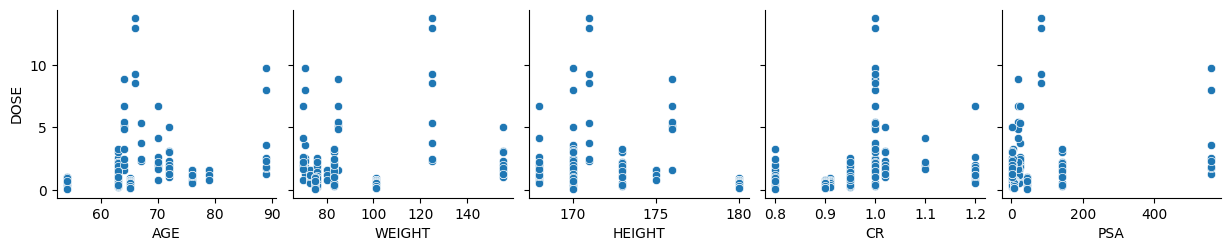

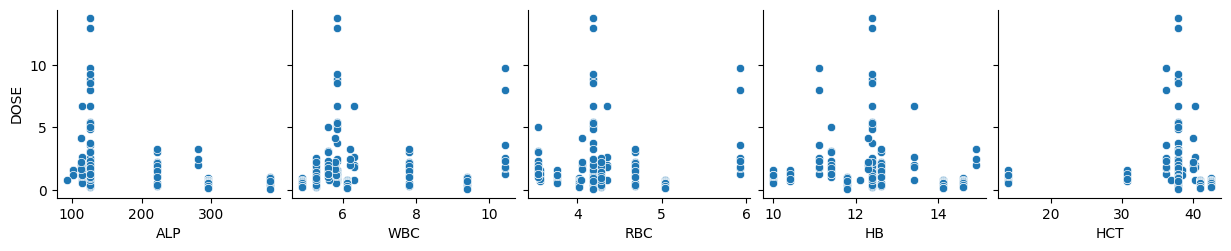

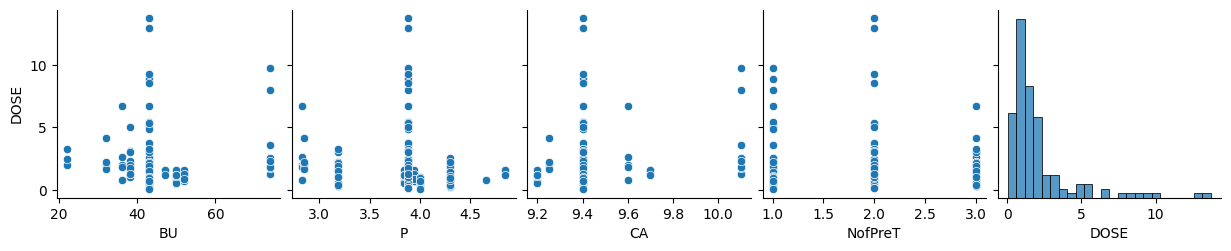

In [35]:
# Pair plots between the lasso selected features in X and the target variable DOSE.
pair_plot(X_selected, y)

In [36]:
# Step 1 selected features
X_selected.columns

Index(['AGE', 'WEIGHT', 'HEIGHT', 'CR', 'PSA', 'ALP', 'WBC', 'RBC', 'HB',
       'HCT', 'BU', 'P', 'CA', 'NofPreT'],
      dtype='object')

In [37]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected)

In [38]:
# Evaluate the gradient boosting model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257151947029329
Mean MAE: 0.4687615138924779
Mean MSE: 0.5051347731009213
Mean RMSE: 0.7107283398746116


Mean Test Scores:
Mean R2 Score: 0.6482163900471823
Mean MAE: 0.5598790978365925
Mean MSE: 0.6535816961369967
Mean RMSE: 0.8084439969082562



Text(0.5, 1.0, 'Feature Importance ')

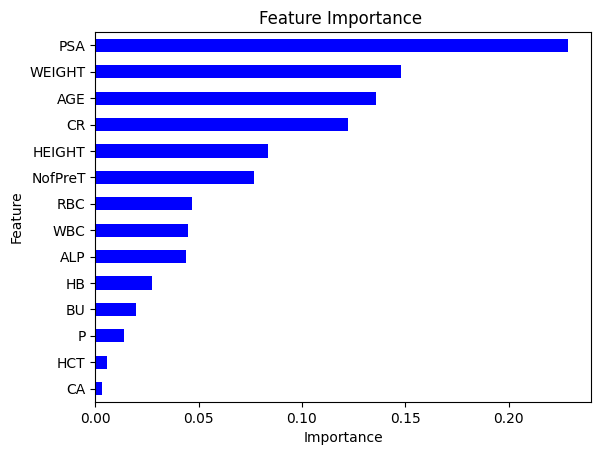

In [39]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from first step with rf feature importance > 0.01

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [40]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature PSA (0.228690)
2. Feature WEIGHT (0.147785)
3. Feature AGE (0.135735)
4. Feature CR (0.122362)
5. Feature HEIGHT (0.083322)
6. Feature NofPreT (0.076979)
7. Feature RBC (0.046620)
8. Feature WBC (0.044882)
9. Feature ALP (0.043776)
10. Feature HB (0.027449)
11. Feature BU (0.019852)
12. Feature P (0.013928)
13. Feature HCT (0.005569)
14. Feature CA (0.003050)


In [41]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [42]:
# Step 2 selected features
X_selected2.columns

Index(['AGE', 'WEIGHT', 'HEIGHT', 'CR', 'PSA', 'ALP', 'WBC', 'RBC', 'HB', 'BU',
       'P', 'NofPreT'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


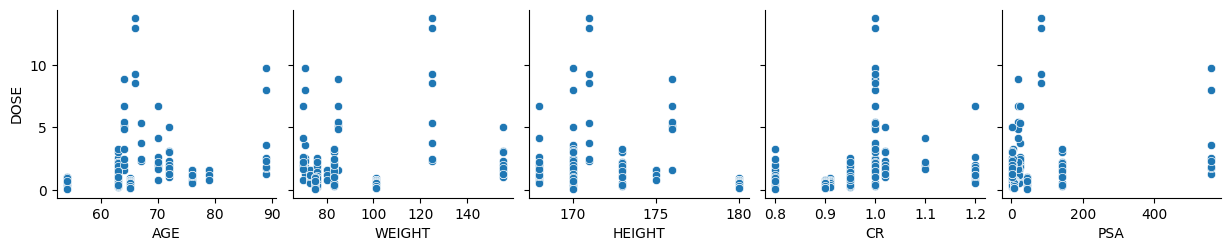

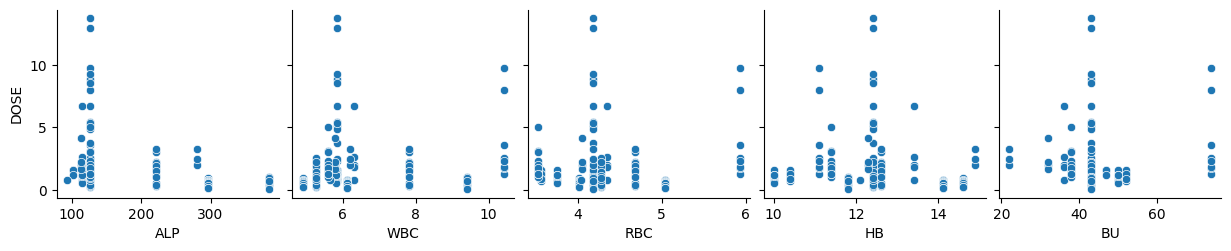

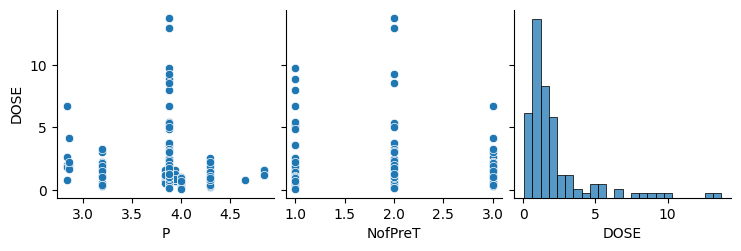

In [43]:
pair_plot(X_selected2, y)

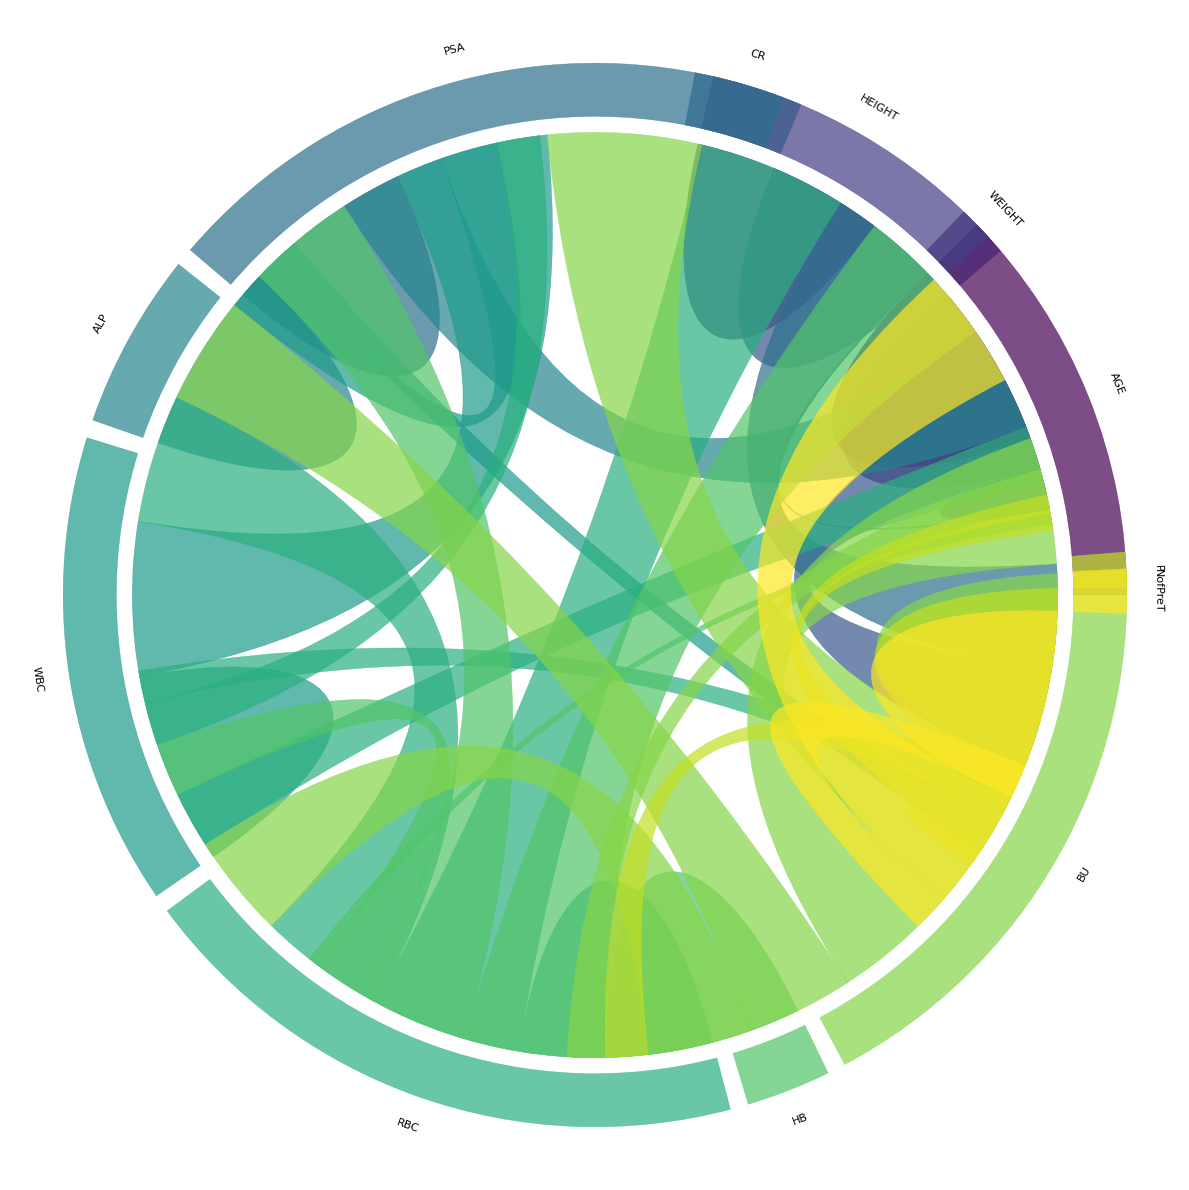

In [44]:
# Chord diagram for visualizing the correlation between selected features
plot_chord_diagram(X_selected2)

In [45]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2)

In [46]:
# Evaluate the gradient boosting model perfonmance on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.825714657258622
Mean MAE: 0.4687987585549038
Mean MSE: 0.5051359566297083
Mean RMSE: 0.7107291724909767


Mean Test Scores:
Mean R2 Score: 0.6481259712008407
Mean MAE: 0.5605871238805494
Mean MSE: 0.6542246950353563
Mean RMSE: 0.8088415759809559



In [47]:
# Step 3: Recursive Feature Elimination (RFE) Using GradientBoostingRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature AGE
2. Feature WEIGHT
3. Feature HEIGHT
4. Feature CR
5. Feature PSA
6. Feature ALP
7. Feature RBC
8. Feature NofPreT


In [48]:
X_selected3 = X_selected2[selected_features]

In [49]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [50]:
X_selected3_sorted.shape

(130, 8)

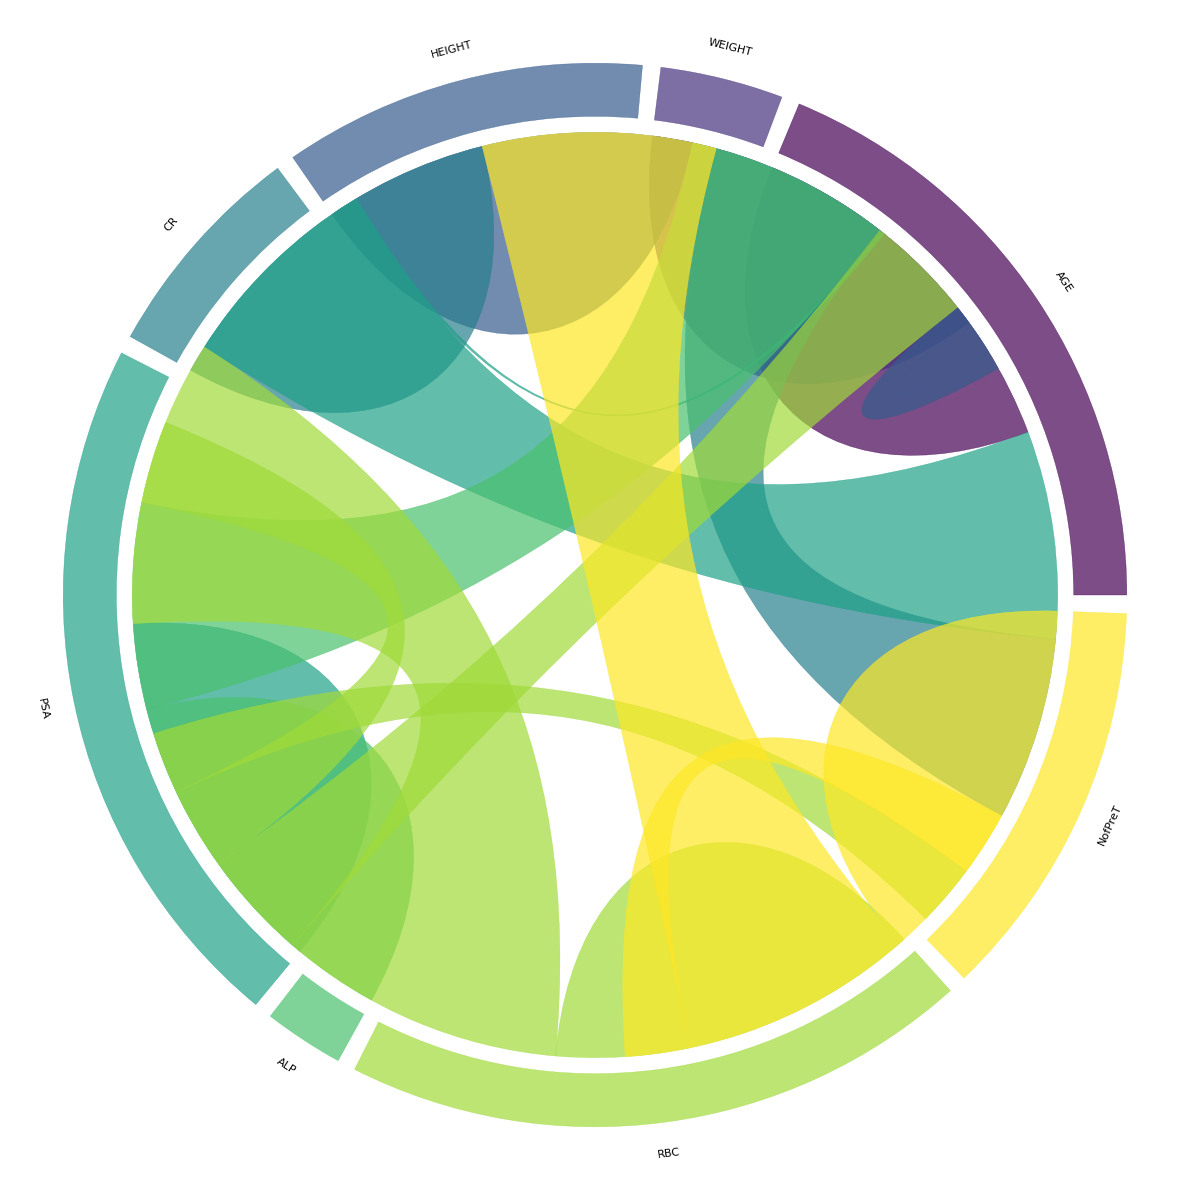

In [51]:
plot_chord_diagram(X_selected3)

In [52]:
# Final 8 selected features
X_selected3.columns

Index(['AGE', 'WEIGHT', 'HEIGHT', 'CR', 'PSA', 'ALP', 'RBC', 'NofPreT'], dtype='object')

In [53]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3)

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_selected3, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 104, Test set:26
Fold:2, Train set: 104, Test set:26
Fold:3, Train set: 104, Test set:26
Fold:4, Train set: 104, Test set:26
Fold:5, Train set: 104, Test set:26


In [55]:
# Final evaluation after 3 step feature selection using GradientBoostingRegressor as a model
# On final 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257145614782111
Mean MAE: 0.4689274654426913
Mean MSE: 0.505136293930949
Mean RMSE: 0.7107294097833219


Mean Test Scores:
Mean R2 Score: 0.643670387224276
Mean MAE: 0.5601466127181196
Mean MSE: 0.6543429398272649
Mean RMSE: 0.8089146678279883



Section 2: One Step Feature Selection Using Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [58]:
# Recursive Feature Elimination (RFE) on the entire dataset
# Using GradientBoostingRegressor as the estimator and select 8 top features

estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_scaled, y)  
selected_features = X.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))

1. Feature AGE
2. Feature WEIGHT
3. Feature HEIGHT
4. Feature CR
5. Feature PSA
6. Feature WBC
7. Feature RBC
8. Feature NofPreT


In [59]:
X_selected = X[selected_features]

In [60]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected_sorted = X.iloc[:, sorted_selected_indices]

In [61]:
X_selected_sorted.shape

(130, 8)

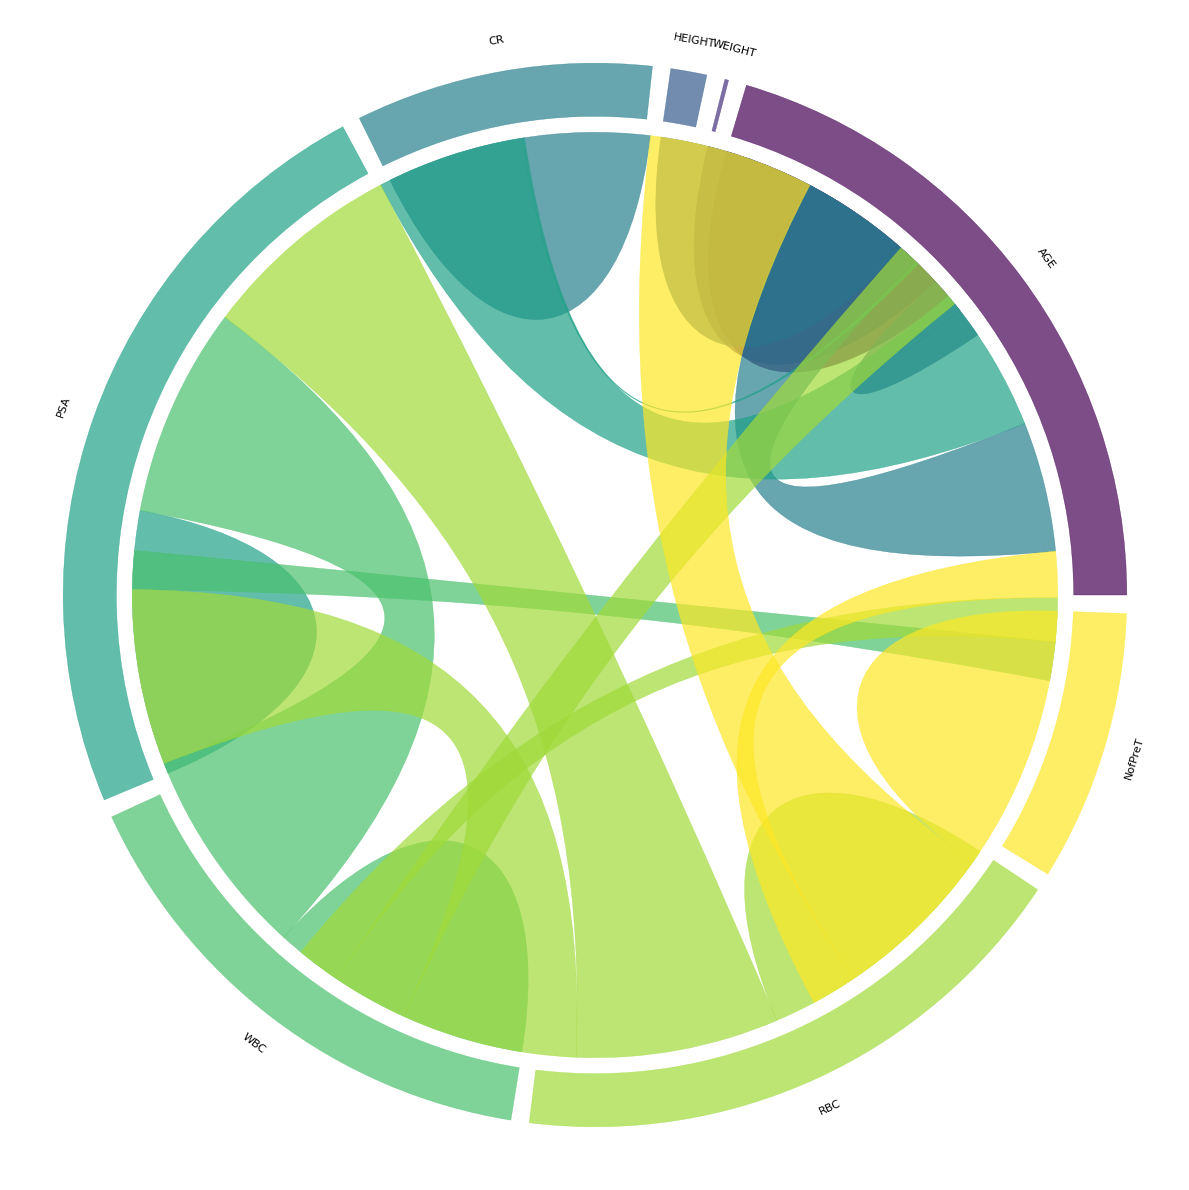

In [62]:
# Correlation between selected features
plot_chord_diagram(X_selected)

In [63]:
# Evaluate the model perfonmance on 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257151947029329
Mean MAE: 0.4687615138924779
Mean MSE: 0.5051347731009213
Mean RMSE: 0.7107283398746116


Mean Test Scores:
Mean R2 Score: 0.6482163900471823
Mean MAE: 0.5598790978365925
Mean MSE: 0.6535816961369967
Mean RMSE: 0.8084439969082562



In [64]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_sorted)

Section 3: Three-Step Feature Selection using Lasso Regression (Starting from 50% feature removal), Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [67]:
# Step1: Remove 30% of features using lasso
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]

feature_coefficients = pd.Series(lasso.coef_, index=X.columns)
sorted_coeffs = feature_coefficients.abs().sort_values(ascending=False)
num_features_to_keep = int((len(X.columns) // 3) * 2)
selected_features = sorted_coeffs[:num_features_to_keep].index

for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature WBC (-0.019130)
2. Feature HB (0.928648)
3. Feature ALP (0.315684)
4. Feature CA (2.417820)
5. Feature CR (0.940297)
6. Feature P (-3.632769)
7. Feature RBC (5.470801)
8. Feature PSA (-1.739363)
9. Feature WEIGHT (5.058063)
10. Feature NofPreT (0.042060)


In [68]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

Weight?,Feature
+5.471,WBC
+5.058,HB
+2.418,CR
+2.106,<BIAS>
+1.811,P
+0.940,PSA
+0.929,WEIGHT
+0.374,BU
+0.316,HEIGHT
+0.042,HCT


In [69]:
X_selected = X[selected_features]

In [70]:
# Step 1 selected features
X_selected.columns

Index(['WBC', 'HB', 'ALP', 'CA', 'CR', 'P', 'RBC', 'PSA', 'WEIGHT', 'NofPreT'], dtype='object')

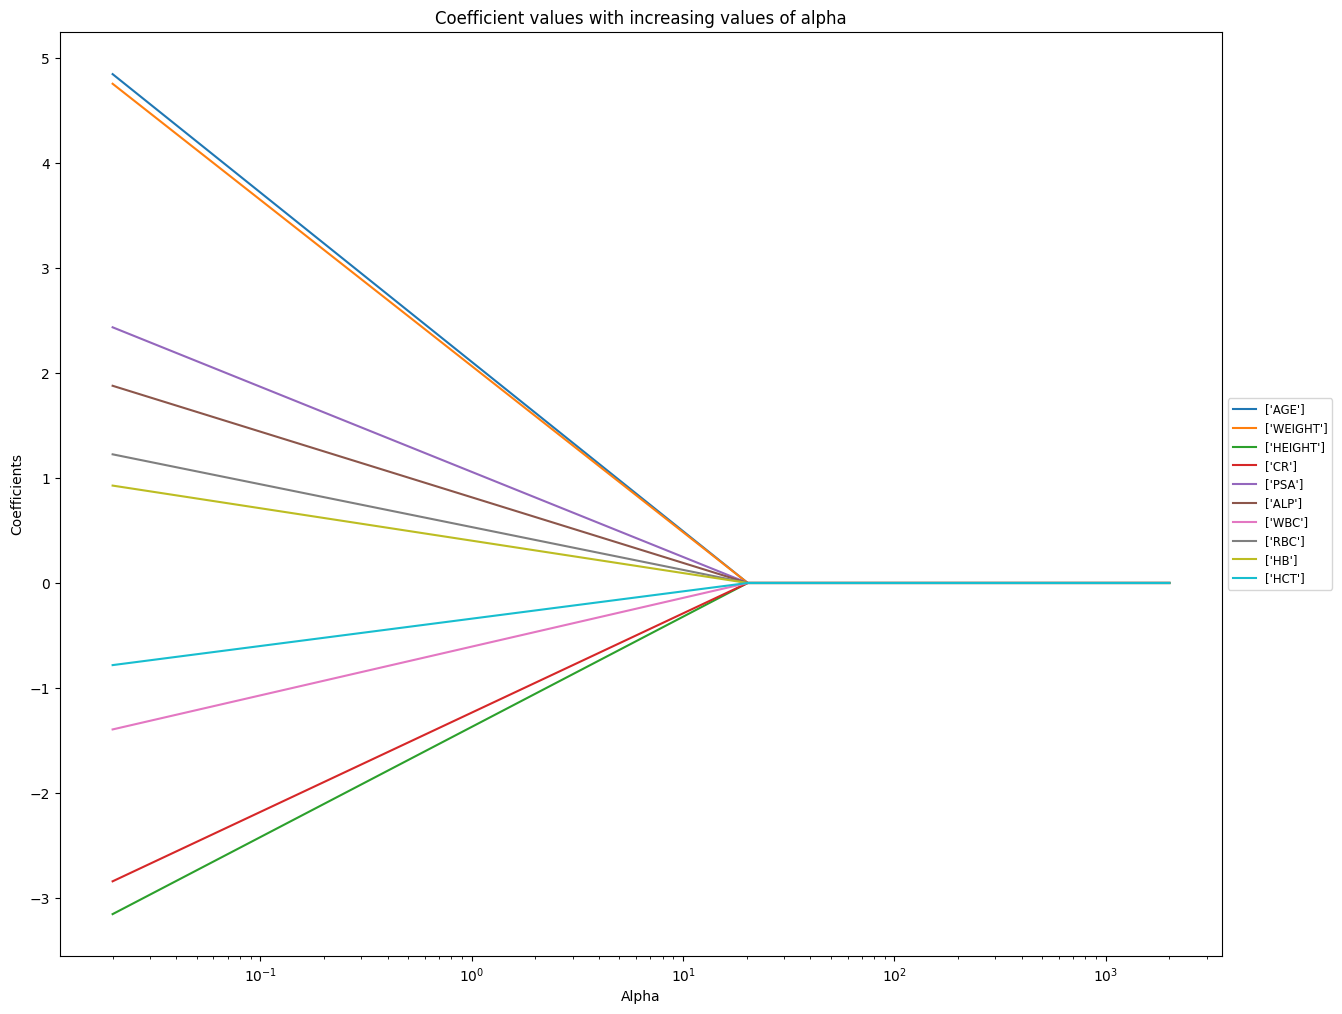

In [71]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()

In [72]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected)

In [73]:
# Evaluate the model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257144298550432
Mean MAE: 0.46878316368043144
Mean MSE: 0.5051364335689017
Mean RMSE: 0.7107295080189803


Mean Test Scores:
Mean R2 Score: 0.6018498233811105
Mean MAE: 0.5887750593419832
Mean MSE: 0.7254819994806325
Mean RMSE: 0.8517523111096512



Text(0.5, 1.0, 'Feature Importance ')

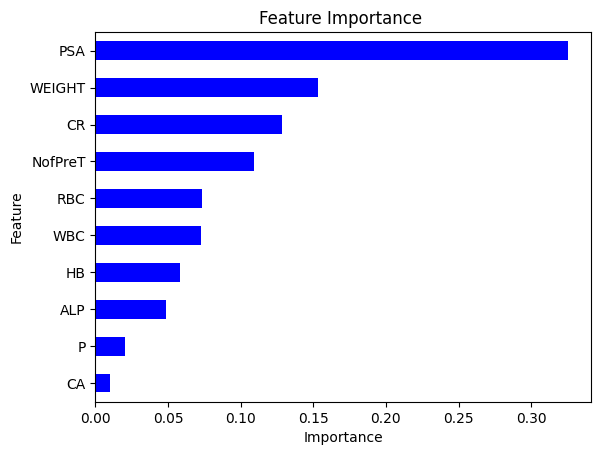

In [74]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from step 1 with rf feature importance > 0.01
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [75]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature PSA (0.325242)
2. Feature WEIGHT (0.153529)
3. Feature CR (0.128690)
4. Feature NofPreT (0.109316)
5. Feature RBC (0.073286)
6. Feature WBC (0.072587)
7. Feature HB (0.058473)
8. Feature ALP (0.048914)
9. Feature P (0.020210)
10. Feature CA (0.009755)


In [76]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [77]:
# Step 2 selected features
X_selected2.columns

Index(['WBC', 'HB', 'ALP', 'CR', 'P', 'RBC', 'PSA', 'WEIGHT', 'NofPreT'], dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


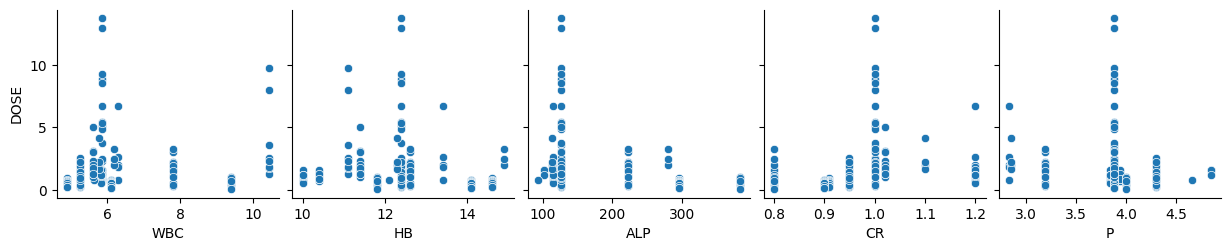

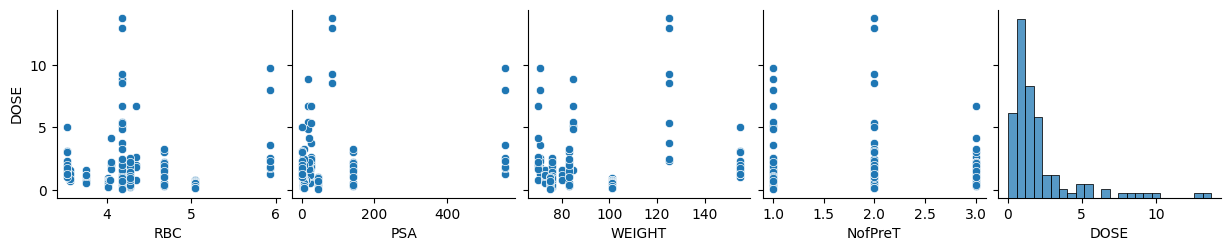

In [78]:
pair_plot(X_selected2, y)

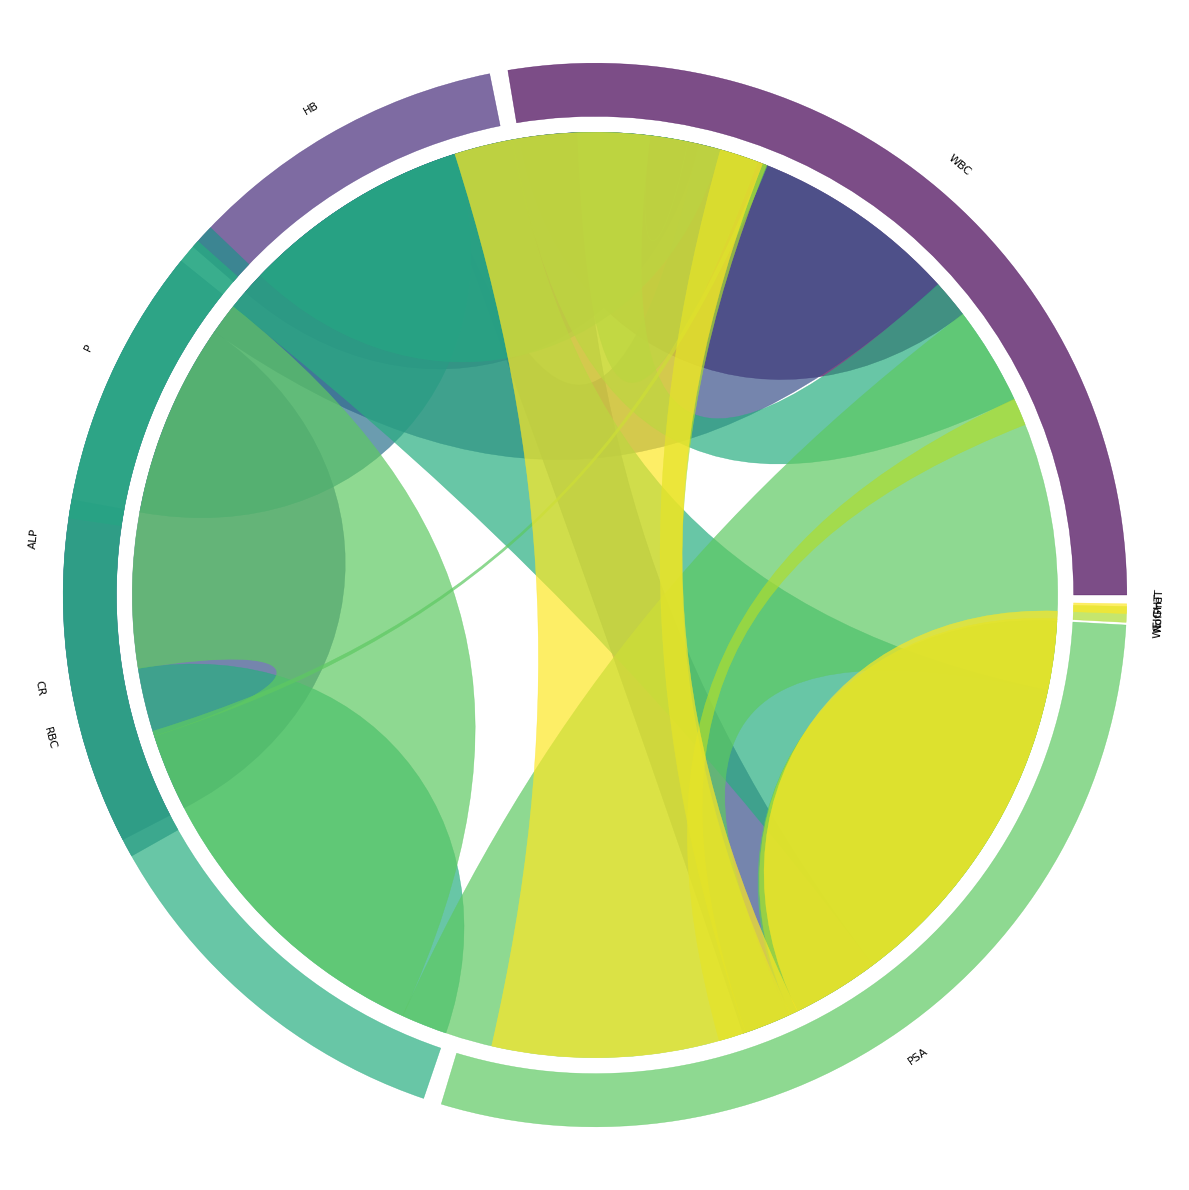

In [79]:
plot_chord_diagram(X_selected2)

In [80]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2)

In [81]:
# Evaluate model perfonmace on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257146997866011
Mean MAE: 0.4687891323754474
Mean MSE: 0.5051358417980361
Mean RMSE: 0.7107290917065631


Mean Test Scores:
Mean R2 Score: 0.6012726880540472
Mean MAE: 0.5891526536327553
Mean MSE: 0.7258842343310584
Mean RMSE: 0.8519884003500626



In [82]:
# Step 3: Recursive Feature Elimination (RFE) Using GradientBoostingRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature WBC
2. Feature HB
3. Feature ALP
4. Feature CR
5. Feature RBC
6. Feature PSA
7. Feature WEIGHT
8. Feature NofPreT


In [83]:
X_selected3 = X_selected2[selected_features]

In [84]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [85]:
X_selected3_sorted.shape

(130, 8)

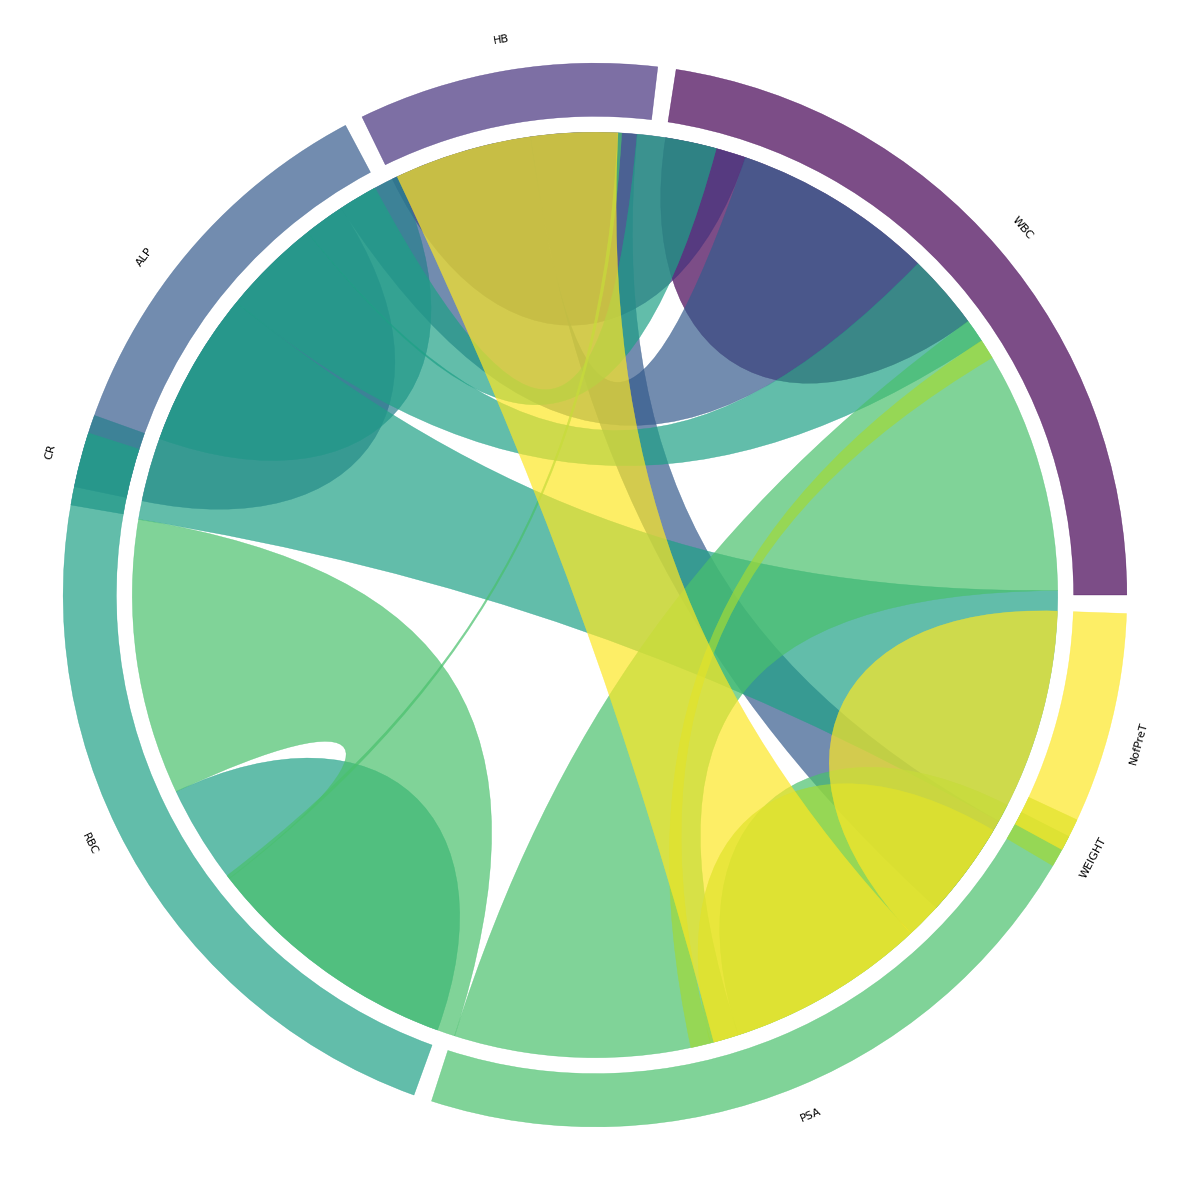

In [86]:
# Correlation plot of final selected features
plot_chord_diagram(X_selected3)

In [87]:
# Final 8 seleted features
X_selected3.columns

Index(['WBC', 'HB', 'ALP', 'CR', 'RBC', 'PSA', 'WEIGHT', 'NofPreT'], dtype='object')

In [88]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3)

In [89]:
# Evaluation on 8 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257146277650486
Mean MAE: 0.46880920821718153
Mean MSE: 0.5051360226759208
Mean RMSE: 0.7107292189546738


Mean Test Scores:
Mean R2 Score: 0.5954942477135987
Mean MAE: 0.5913300337606995
Mean MSE: 0.7307485089592797
Mean RMSE: 0.8548382940412064



In [92]:
# Evaluation on 4 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled[:, :4], y, model)    


Mean Train Scores:
Mean R2 Score: 0.8257152393565482
Mean MAE: 0.468664231691001
Mean MSE: 0.5051346315308259
Mean RMSE: 0.710728240279522


Mean Test Scores:
Mean R2 Score: 0.6490353622810804
Mean MAE: 0.5586390786753823
Mean MSE: 0.6532717610856136
Mean RMSE: 0.8082522880175559

